# Hurricane Prediction

## Intro

The idea is to predict hurricane entry based on a set of weather conditions that are measured in the USA.

In [15]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from datetime import datetime, timedelta
from IPython.display import clear_output

In [2]:
def render_plots_numbers(data):
    values = data.values
    cols_to_plot = [col for col in range(1, len(data.columns)) if type(values[0, col]) != str]
    pyplot.figure(figsize=(10, len(cols_to_plot) * 1.2))
    i = 1
    for group in cols_to_plot:
        pyplot.subplot(len(cols_to_plot), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(data.columns[group], y=1, loc='right')
        i += 1
    pyplot.tight_layout(h_pad=1)
    pyplot.show()

In [32]:
houston_weather = read_csv('HurricaneData/Preprocessed/houston.csv', index_col=0)
hurdat_houston = read_csv('HurricaneData/Preprocessed/hurdat_houston.csv', index_col=0)

houston_weather.index = pd.to_datetime(houston_weather.index)
hurdat_houston.index = pd.to_datetime(hurdat_houston.index)

In [33]:
hurdat_houston

,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,A
Date,,,,,,,,,,,,,,,,,,,,
1853-09-09 00:00:00,UNNAMED,,HU,390.0,623.0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1854-09-11 18:00:00,UNNAMED,,HU,395.0,618.0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,18
1856-09-03 00:00:00,UNNAMED,,TS,382.0,618.0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1858-09-22 00:00:00,UNNAMED,,HU,390.0,636.0,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1859-07-01 12:00:00,UNNAMED,,HU,215.0,975.0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,12
1862-08-20 06:00:00,UNNAMED,,HU,397.0,625.0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,6
1863-09-09 12:00:00,UNNAMED,,HU,202.0,620.0,70,0,0,0,0,0,0,0,0,0,0,0,0,0,12
1863-09-09 18:00:00,UNNAMED,,HU,214.0,626.0,70,0,0,0,0,0,0,0,0,0,0,0,0,0,18
1866-08-18 00:00:00,UNNAMED,,TS,205.0,985.0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0


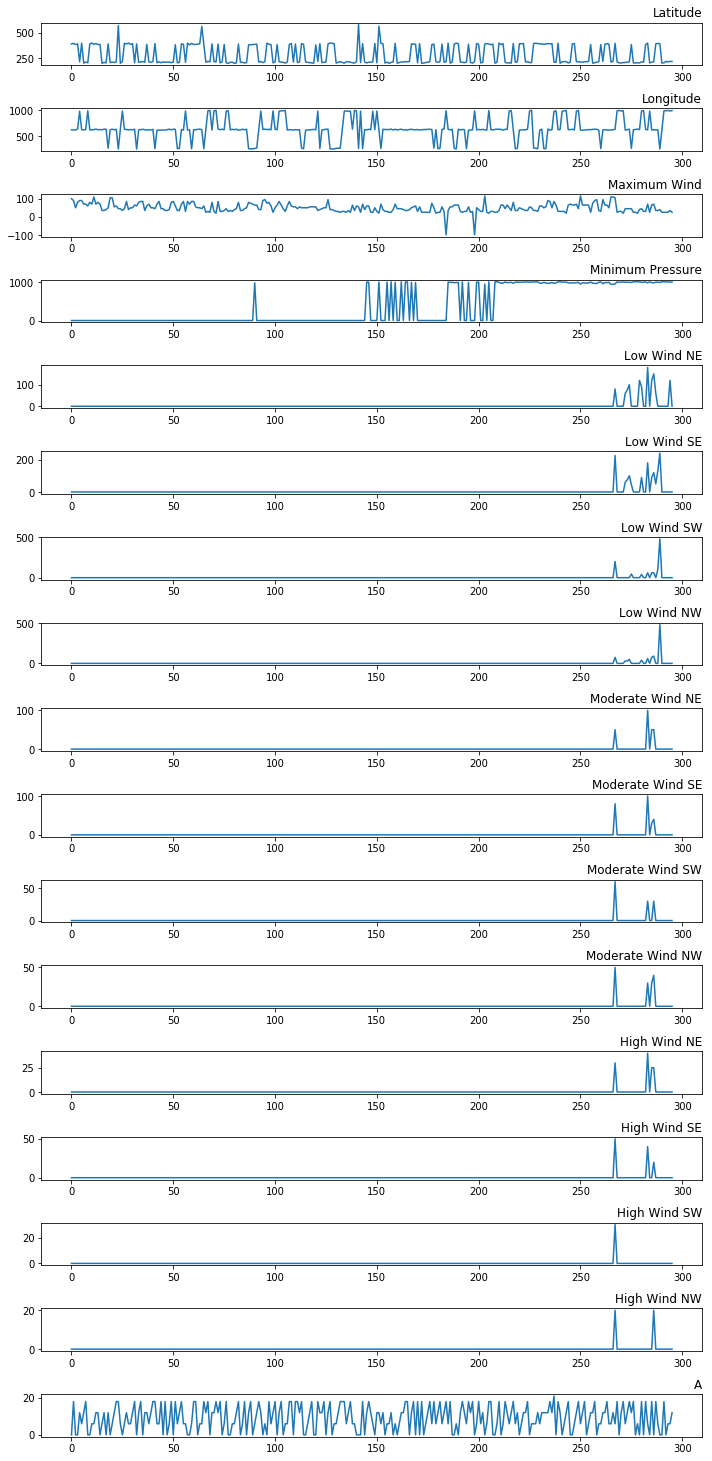

In [5]:
render_plots_numbers(hurdat_houston)

In [38]:
houston_weather

pandas.core.indexes.datetimes.DatetimeIndex

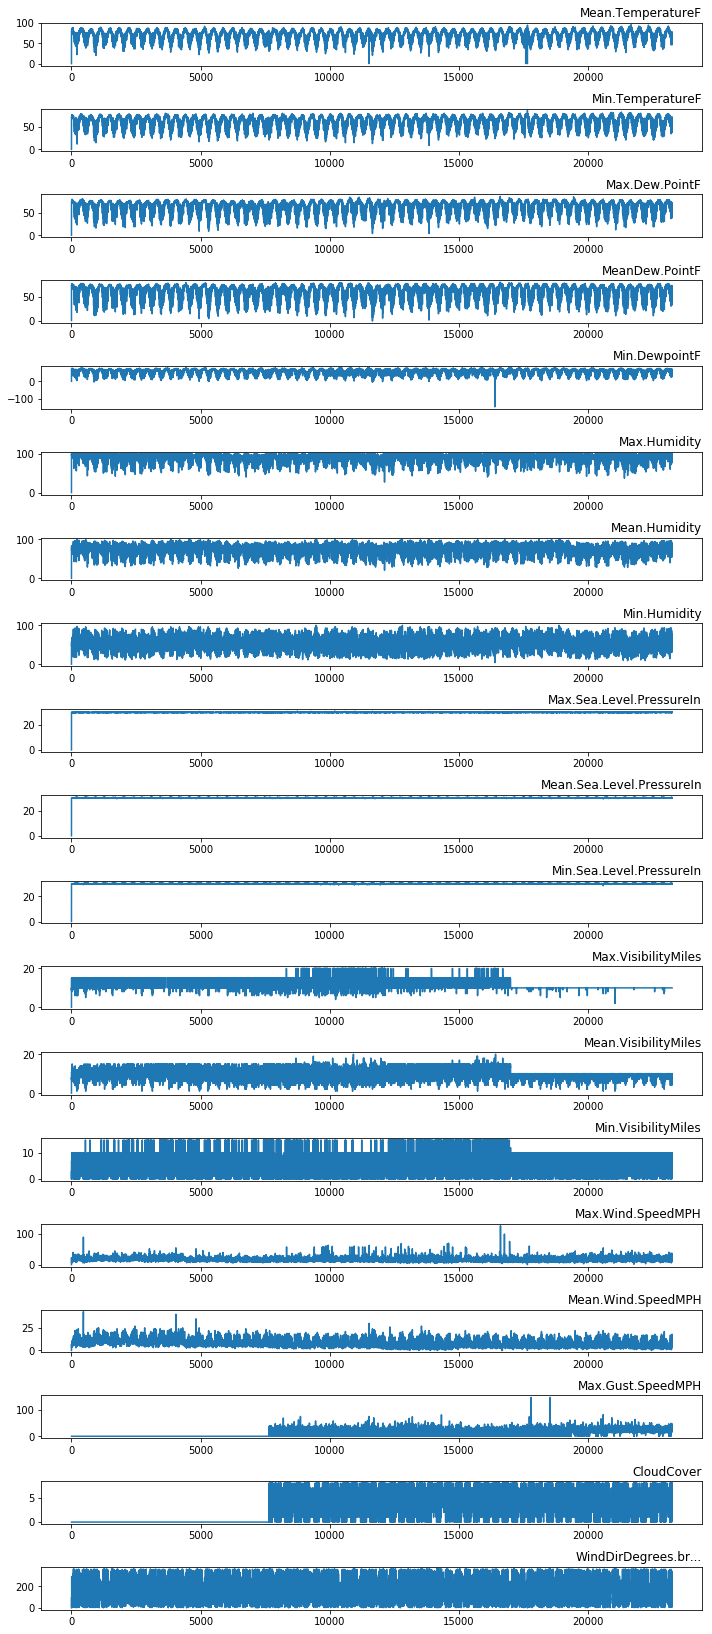

In [7]:
render_plots_numbers(houston_weather)

In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [50]:
houston_to_supervise = houston_weather.loc[:, ['season', 'Events', 'Max.TemperatureF', 'Max.Dew.PointF', 'Max.Humidity', 'Max.Wind.SpeedMPH', 'Max.Sea.Level.PressureIn']]
houston_to_supervise

,season,Events,Max.TemperatureF,Max.Dew.PointF,Max.Humidity,Max.Wind.SpeedMPH,Max.Sea.Level.PressureIn
Date,,,,,,,
1948-06-30,Summer,0,0.0,0.0,0.0,0.0,0.00
1948-07-01,Summer,Fog,90.0,74.0,100.0,23.0,30.11
1948-07-02,Summer,Fog-Rain-Thunderstorm,87.0,76.0,97.0,14.0,30.12
1948-07-03,Summer,Fog-Rain,84.0,79.0,100.0,10.0,30.08
1948-07-04,Summer,Fog-Rain-Thunderstorm,88.0,77.0,97.0,12.0,30.05
1948-07-05,Summer,Rain-Thunderstorm,88.0,76.0,94.0,14.0,30.08
1948-07-06,Summer,Fog,95.0,75.0,97.0,12.0,30.05
1948-07-07,Summer,Fog,96.0,75.0,93.0,5.0,29.97
1948-07-08,Summer,Fog-Rain-Thunderstorm,91.0,75.0,97.0,13.0,29.98


In [10]:
values = houston_to_supervise.values

encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])

encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])

values

array([[2, 0, 0.0, ..., 0.0, 0.0, 0.0],
       [2, 1, 90.0, ..., 100.0, 23.0, 30.11],
       [2, 6, 87.0, ..., 97.0, 14.0, 30.12],
       ..., 
       [3, 0, 52.0, ..., 80.0, 13.0, 30.15],
       [3, 11, 57.0, ..., 93.0, 16.0, 30.23],
       [3, 11, 55.0, ..., 77.0, 17.0, 30.34]], dtype=object)

In [75]:
if 'Hurricane_Started' in houston_to_supervise:
    del houston_to_supervise['Hurricane_Started']
houston_to_supervise.insert(len(houston_to_supervise.columns), 'Hurricane_Started', 0)
for i, row in enumerate(houston_to_supervise.itertuples()):
    date_range = timedelta(days=2)
    start_date = row[0] - date_range
    end_date = row[0] + date_range
    mask = (hurdat_houston.index > start_date) & (hurdat_houston.index <= end_date)
    found_hurricane = len(hurdat_houston[mask].index) > 0
    if found_hurricane:
        houston_to_supervise.set_value(row[0], 'Hurricane_Started', 1)
houston_to_supervise[houston_to_supervise['Hurricane_Started'] == 1]

,season,Events,Max.TemperatureF,Max.Dew.PointF,Max.Humidity,Max.Wind.SpeedMPH,Max.Sea.Level.PressureIn,Hurricane_Started
Date,,,,,,,,
1948-08-25,Summer,Fog-Rain-Thunderstorm,84.0,75.0,100.0,18.0,29.92,1
1948-08-26,Summer,Fog-Rain-Thunderstorm,88.0,76.0,100.0,22.0,29.93,1
1948-08-27,Summer,Rain,88.0,77.0,100.0,16.0,30.04,1
1948-08-28,Summer,Rain-Thunderstorm,88.0,75.0,97.0,20.0,30.08,1
1948-09-13,Summer,0,84.0,72.0,91.0,15.0,29.95,1
1948-09-14,Summer,0,78.0,71.0,91.0,15.0,30.04,1
1948-09-15,Summer,0,88.0,71.0,87.0,24.0,30.05,1
1948-09-16,Summer,Rain,82.0,75.0,96.0,26.0,30.06,1
1948-09-23,Autumn,Fog,90.0,72.0,100.0,14.0,29.73,1


In [ ]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head(), values.shape)